### Notebook to check the dates of the MRI scans

#### Date Sources
1. Suivi sheet 
2. Testing sheet
3. DICOM file 
4. DICOM header

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [13]:
dataset_dir  = "/home/nikhil/projects/Parkinsons/qpn/"

current_release = "Sept_2023"
releases_dir = f"{dataset_dir}releases/{current_release}/"


# Current mr_proc manifest
current_manifest_csv = f"{releases_dir}/tabular/manifest.csv"

# Current recruit manifest
current_recruit_manifest_xls = f"{releases_dir}/tabular/Suivi_RPQ.xlsx"

# Doughnut path
doughnut_path = f"{dataset_dir}/scratch/raw_dicom/doughnut-20230919_1433.csv"

# Date check CSV path
date_check_csv = f"{dataset_dir}/scratch/mri_dates_sanity_check.csv"

### Read current manifest

In [3]:
manifest_df= pd.read_csv(current_manifest_csv)

manifest_participants = manifest_df["participant_id"].unique()
n_manifest_participants = len(manifest_participants)
print(f"Number of participants in manifest: {n_manifest_participants}")

sessions = manifest_df["session"].unique()
print(f"sessions: {sessions}")

per_session_counts = manifest_df.value_counts("session")
print(f"per_session_counts: {per_session_counts}")

manifest_df.head()

Number of participants in manifest: 265
sessions: ['ses-01' 'ses-02']
per_session_counts: session
ses-01    265
ses-02     48
Name: count, dtype: int64


,participant_id,visit,session,datatype
0,PD00016,MRI_v1,ses-01,"['anat','dwi','fmap','func']"
1,PD00020,MRI_v1,ses-01,"['anat','dwi','fmap','func']"
2,PD00032,MRI_v1,ses-01,"['anat','dwi','fmap','func']"
3,PD00048,MRI_v1,ses-01,"['anat','dwi','fmap','func']"
4,PD00119,MRI_v1,ses-01,"['anat','dwi','fmap','func']"


### Read doughnut data

In [4]:
doughnut_df = pd.read_csv(doughnut_path)

manifest_participants = doughnut_df["participant_id"].unique()
n_manifest_participants = len(manifest_participants)
print(f"Number of participants in manifest: {n_manifest_participants}")

sessions = doughnut_df["session"].unique()
print(f"sessions: {sessions}")

per_session_counts = doughnut_df.value_counts("session")
print(f"per_session_counts: {per_session_counts}")

doughnut_df.head()

Number of participants in manifest: 265
sessions: ['ses-01' 'ses-02']
per_session_counts: session
ses-01    265
ses-02     48
Name: count, dtype: int64


,participant_id,session,participant_dicom_dir,dicom_id,bids_id,downloaded,organized,converted
0,MNI0056,ses-01,MNI0056_864854_MRI01_MNI_20210818_151510608,MNI0056,sub-MNI0056,True,True,True
1,MNI0058,ses-01,MNI0058_197308_MRI01_MNI_20210818_105219098,MNI0058,sub-MNI0058,True,True,True
2,MNI0068,ses-01,MNI0068_842090_MRI01_MNI_20210827_150412426,MNI0068,sub-MNI0068,True,True,True
3,MNI0079,ses-01,MNI0079_760662_MRI01_MNI_20211222_134225878,MNI0079,sub-MNI0079,True,True,True
4,MNI0103,ses-01,MNI0103_369057_MRI01_MNI_20211116_132143505,MNI0103,sub-MNI0103,True,True,True


### Read Suivi_RPQ.xlsx dates for MRI

In [5]:
col_range = "A:N"

col_rename_dict = {"Unnamed: 0":"participant_id",
                "IRM01\n(J-M-A)":"IRM01_date", "#IRM 1\n PD":"IRM01_PD", "#IRM 1\n CTRL":"IRM01_CTRL", "# IRM 1\n RBD":"IRM01_RBD",
                "IRM 2 \n(J-M-A)":"IRM02_date", "#IRM 2\n PD":"IRM02_PD", "#IRM 2\n CTRL":"IRM02_CTRL", "# IRM 2\n RBD":"IRM02_RBD"}

useful_cols = col_rename_dict.values()

suivi_df = pd.read_excel(current_recruit_manifest_xls,sheet_name="En cours", engine='openpyxl', usecols=col_range)
suivi_df = suivi_df.rename(columns=col_rename_dict)[useful_cols].copy()

# remove the row with tally
suivi_df = suivi_df.drop([0])

# remove rows without participant_id
suivi_df = suivi_df.dropna(axis=0, subset=["participant_id"])
suivi_df = suivi_df[~suivi_df["participant_id"].astype(str).isin(["0"])] 

# remove subjects without imaging data
suivi_df = suivi_df[(suivi_df["IRM01_PD"] == 1) | (suivi_df["IRM01_CTRL"] == 1) | (suivi_df["IRM01_RBD"] == 1) | 
                    (suivi_df["IRM02_PD"] == 1) | (suivi_df["IRM02_CTRL"] == 1) | (suivi_df["IRM02_RBD"] == 1)]


# fix participant_id formatting issues
# Some rows have Dx in participant_id and one participant with two IDs with "="
possible_delimiters = [" ", "(", "="]
for delim in possible_delimiters:
    suivi_df["participant_id"] = suivi_df["participant_id"].str.split(pat=delim, n=1, expand=True)[0]

# nipoppy_participants_current
nipoppy_participants_current = suivi_df["participant_id"].dropna().unique()

suivi_df.head()

,participant_id,IRM01_date,IRM01_PD,IRM01_CTRL,IRM01_RBD,IRM02_date,IRM02_PD,IRM02_CTRL,IRM02_RBD
15,PD00016,26-07-2019,1.0,0.0,0.0,0,NaN,NaN,NaN
19,PD00020,2018-05-12 00:00:00,1.0,0.0,0.0,24-11-2022,1.0,0.0,0.0
31,PD00032,24-07-2019,1.0,0.0,0.0,0,NaN,NaN,NaN
47,PD00048,21-08-2019,1.0,0.0,0.0,0,NaN,NaN,NaN
117,PD00119,13-08-2018,1.0,0.0,0.0,0,NaN,NaN,NaN


In [16]:
suivi_df[suivi_df["participant_id"].isin(["MNI0224"])]

,participant_id,IRM01_date,IRM01_PD,IRM01_CTRL,IRM01_RBD,IRM02_date,IRM02_PD,IRM02_CTRL,IRM02_RBD,visit_interval (V2-V1) in days
1793,MNI0224,2022-03-16,0.0,1.0,0.0,NaT,NaN,NaN,NaN,NaN


In [6]:
# set date columns to datetime
# has mixed types, but auto formatting + coerce works fine here
suivi_df["IRM01_date"] = suivi_df["IRM01_date"].replace(0, np.nan)
suivi_df["IRM02_date"] = suivi_df["IRM02_date"].replace(0, np.nan)

suivi_df["IRM01_date"] = pd.to_datetime(suivi_df["IRM01_date"], errors="coerce")
suivi_df["IRM02_date"] = pd.to_datetime(suivi_df["IRM02_date"], errors="coerce")


# Check visit orders
suivi_df["visit_interval (V2-V1) in days"] = suivi_df["IRM02_date"] - suivi_df["IRM01_date"]
suivi_df["visit_interval (V2-V1) in days"] = suivi_df["visit_interval (V2-V1) in days"].dt.days
visits_wit_wrong_order_df = suivi_df[suivi_df["visit_interval (V2-V1) in days"] < 0]
print(f"Participants with wrong visit order: ({len(visits_wit_wrong_order_df)}) :{visits_wit_wrong_order_df['participant_id'].values}")


suivi_df.head()

Participants with wrong visit order: (0) :[]


/tmp/ipykernel_1871837/504833383.py:6: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  suivi_df["IRM01_date"] = pd.to_datetime(suivi_df["IRM01_date"], errors="coerce")
/tmp/ipykernel_1871837/504833383.py:7: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  suivi_df["IRM02_date"] = pd.to_datetime(suivi_df["IRM02_date"], errors="coerce")


,participant_id,IRM01_date,IRM01_PD,IRM01_CTRL,IRM01_RBD,IRM02_date,IRM02_PD,IRM02_CTRL,IRM02_RBD,visit_interval (V2-V1) in days
15,PD00016,2019-07-26,1.0,0.0,0.0,NaT,NaN,NaN,NaN,NaN
19,PD00020,2018-05-12,1.0,0.0,0.0,2022-11-24,1.0,0.0,0.0,1657.0
31,PD00032,2019-07-24,1.0,0.0,0.0,NaT,NaN,NaN,NaN,NaN
47,PD00048,2019-08-21,1.0,0.0,0.0,NaT,NaN,NaN,NaN,NaN
117,PD00119,2018-08-13,1.0,0.0,0.0,NaT,NaN,NaN,NaN,NaN


### Parse and merge dates and visits

In [7]:
suivi_date_df = suivi_df[['participant_id', 'IRM01_date', 'IRM02_date']].copy()

suivi_date_df = suivi_date_df.melt(id_vars=['participant_id'], 
                                   value_vars=['IRM01_date', 'IRM02_date'], 
                                   var_name='visit', value_name='suivi_date')

suivi_date_df = suivi_date_df.replace({"visit": {"IRM01_date": "MRI01", "IRM02_date": "MRI02"}})
suivi_date_df.head()

,participant_id,visit,suivi_date
0,PD00016,MRI01,2019-07-26
1,PD00020,MRI01,2018-05-12
2,PD00032,MRI01,2019-07-24
3,PD00048,MRI01,2019-08-21
4,PD00119,MRI01,2018-08-13


In [19]:
doughnut_date_df = doughnut_df[["participant_id", "session", "participant_dicom_dir"]].copy()
doughnut_date_df["visit"] = doughnut_date_df["participant_dicom_dir"].str.split("_", n=3, expand=True)[2]
doughnut_date_df["dicom_date"] = doughnut_date_df["participant_dicom_dir"].str.split("_", n=5, expand=True)[4]
doughnut_date_df["dicom_date"] = pd.to_datetime(doughnut_date_df["dicom_date"], errors="coerce", yearfirst=True)

participants_with_missing_dicom_visit_tag = doughnut_date_df[doughnut_date_df["visit"].isna()]["participant_id"].unique()
print(f"participants_with_missing_dicom_visit_tag: {participants_with_missing_dicom_visit_tag}")
doughnut_date_df.head()

participants_with_missing_dicom_visit_tag: ['MNI0224' 'MNI0326' 'MNI0350' 'MNI0369' 'MNI0436' 'PD00472' 'PD00576'
 'PD00583' 'PD00620' 'PD00792' 'PD00849' 'PD00911' 'PD01067' 'PD01071'
 'PD01100' 'PD01126' 'PD01134' 'PD01161' 'PD01165' 'PD01199' 'PD01201'
 'PD01232' 'PD01237' 'PD01247' 'PD01268' 'PD01340' 'PD01383' 'PD01500'
 'PD01709' 'PD01715']


,participant_id,session,participant_dicom_dir,visit,dicom_date
0,MNI0056,ses-01,MNI0056_864854_MRI01_MNI_20210818_151510608,MRI01,2021-08-18
1,MNI0058,ses-01,MNI0058_197308_MRI01_MNI_20210818_105219098,MRI01,2021-08-18
2,MNI0068,ses-01,MNI0068_842090_MRI01_MNI_20210827_150412426,MRI01,2021-08-27
3,MNI0079,ses-01,MNI0079_760662_MRI01_MNI_20211222_134225878,MRI01,2021-12-22
4,MNI0103,ses-01,MNI0103_369057_MRI01_MNI_20211116_132143505,MRI01,2021-11-16


### Assign doughnut visit tag based on session_id

In [20]:
doughnut_date_df.loc[doughnut_date_df["visit"].isna(), "visit"] = "MRI" + doughnut_date_df["session"].str.split("-", n=2, expand=True)[1]

participants_with_missing_dicom_visit_tag = doughnut_date_df[doughnut_date_df["visit"].isna()]["participant_id"].unique()
print(f"participants_with_missing_dicom_visit_tag: {participants_with_missing_dicom_visit_tag}")

doughnut_date_df.head()

participants_with_missing_dicom_visit_tag: []


,participant_id,session,participant_dicom_dir,visit,dicom_date
0,MNI0056,ses-01,MNI0056_864854_MRI01_MNI_20210818_151510608,MRI01,2021-08-18
1,MNI0058,ses-01,MNI0058_197308_MRI01_MNI_20210818_105219098,MRI01,2021-08-18
2,MNI0068,ses-01,MNI0068_842090_MRI01_MNI_20210827_150412426,MRI01,2021-08-27
3,MNI0079,ses-01,MNI0079_760662_MRI01_MNI_20211222_134225878,MRI01,2021-12-22
4,MNI0103,ses-01,MNI0103_369057_MRI01_MNI_20211116_132143505,MRI01,2021-11-16


### Merge

In [21]:
date_sanity_check_df = pd.merge(doughnut_date_df, suivi_date_df, on=["participant_id", "visit"], how="left")
reorder_cols = ["participant_id", "visit", "session", "participant_dicom_dir", "suivi_date", "dicom_date"]
date_sanity_check_df = date_sanity_check_df[reorder_cols]
date_sanity_check_df["date_match"] = date_sanity_check_df["suivi_date"] == date_sanity_check_df["dicom_date"]
date_sanity_check_df["date_diff"] = date_sanity_check_df["suivi_date"] - date_sanity_check_df["dicom_date"]

# Don't count unavailable dates as mismatches 
date_sanity_check_df.loc[date_sanity_check_df["date_diff"].isna(), "date_match"] = np.nan

date_sanity_check_df


/tmp/ipykernel_1871837/2253791382.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  date_sanity_check_df.loc[date_sanity_check_df["date_diff"].isna(), "date_match"] = np.nan


,participant_id,visit,session,participant_dicom_dir,suivi_date,dicom_date,date_match,date_diff
0,MNI0056,MRI01,ses-01,MNI0056_864854_MRI01_MNI_20210818_151510608,2021-08-18,2021-08-18,True,0 days
1,MNI0058,MRI01,ses-01,MNI0058_197308_MRI01_MNI_20210818_105219098,2021-08-18,2021-08-18,True,0 days
2,MNI0068,MRI01,ses-01,MNI0068_842090_MRI01_MNI_20210827_150412426,2021-08-27,2021-08-27,True,0 days
3,MNI0079,MRI01,ses-01,MNI0079_760662_MRI01_MNI_20211222_134225878,2021-12-22,2021-12-22,True,0 days
4,MNI0103,MRI01,ses-01,MNI0103_369057_MRI01_MNI_20211116_132143505,2021-08-11,2021-11-16,False,-97 days
...,...,...,...,...,...,...,...,...
308,PD01758,MRI01,ses-01,PD01758_821221_MRI01_MNI,2021-10-06,NaT,NaN,NaT
309,PD01758,MRI02,ses-02,PD01758_821221_MRI02_MNI,NaT,NaT,NaN,NaT
310,PD01759,MRI01,ses-01,PD01759_757223_MRI01_MNI_20211006_134120088,2021-06-10,2021-10-06,False,-118 days
311,PD01759,MRI02,ses-02,PD01759_757223_MRI02_MNI_20221111_143222853,NaT,2022-11-11,NaN,NaT


In [22]:
date_sanity_check_df.groupby(["visit","session","date_match"])["participant_id"].count()

visit  session  date_match
MRI01  ses-01   False         65
                True          88
MRI02  ses-02   False          6
                True           8
Name: participant_id, dtype: int64

In [23]:
date_sanity_check_df[date_sanity_check_df["date_match"] == False]

,participant_id,visit,session,participant_dicom_dir,suivi_date,dicom_date,date_match,date_diff
4,MNI0103,MRI01,ses-01,MNI0103_369057_MRI01_MNI_20211116_132143505,2021-08-11,2021-11-16,False,-97 days
8,MNI0136,MRI01,ses-01,MNI0136_587352_MRI01_MNI_20210902_133914355,2021-08-27,2021-09-02,False,-6 days
10,MNI0144,MRI01,ses-01,MNI0144_909399_MRI01_MNI_20211112_095531843,2021-12-11,2021-11-12,False,29 days
14,MNI0168,MRI01,ses-01,MNI0168_945911_MRI01_MNI_20211203_161111178,2021-03-12,2021-12-03,False,-266 days
15,MNI0178,MRI01,ses-01,MNI0178_692462_MRI01_MNI_20211208_140005415,2021-08-12,2021-12-08,False,-118 days
...,...,...,...,...,...,...,...,...
298,PD01738,MRI01,ses-01,PD01738_349683_MRI01_MNI_20210910_130302554,2021-10-09,2021-09-10,False,29 days
300,PD01746,MRI01,ses-01,PD01746_898695_MRI01_MNI_20220531_102605810,2021-02-07,2022-05-31,False,-478 days
306,PD01756,MRI01,ses-01,PD01756_350030_MRI01_MNI_20211008_103930437,2021-08-10,2021-10-08,False,-59 days
310,PD01759,MRI01,ses-01,PD01759_757223_MRI01_MNI_20211006_134120088,2021-06-10,2021-10-06,False,-118 days


### Plot mismatched date distributions

/home/nikhil/projects/my_venvs/nipoppy/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nikhil/projects/my_venvs/nipoppy/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nikhil/projects/my_venvs/nipoppy/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nikhil/projects/my_venvs/nipoppy/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be r

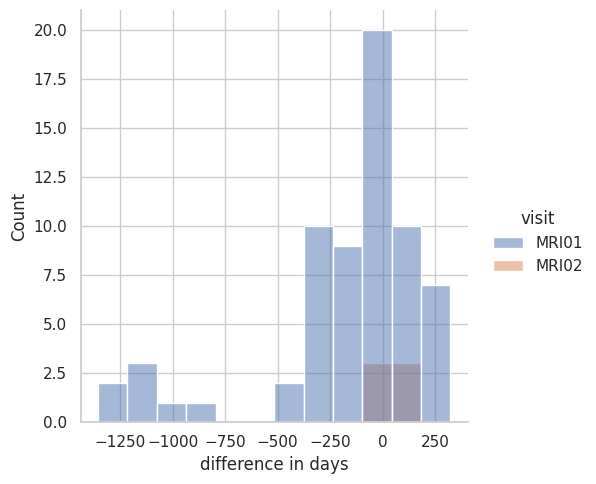

In [24]:
plot_df = date_sanity_check_df.copy()
plot_df = plot_df[plot_df["date_match"] == False]
plot_df["difference in days"] = plot_df["date_diff"].dt.days

sns.set(font_scale=1)
with sns.axes_style("whitegrid"):
    g = sns.displot(hue="visit", x="difference in days", data=plot_df)

In [25]:
save_date_check_csv = False
if save_date_check_csv:
    print(f"Saving save_date_check_csv here: {date_check_csv}")
    date_sanity_check_df.to_csv(date_check_csv,index=None)

Saving save_date_check_csv here: /home/nikhil/projects/Parkinsons/qpn//scratch/mri_dates_sanity_check.csv
